In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import columnas_utils as col
import pandas as pd
%cd ..\..\etabs_oapi
import sismo_utils as sis
import etabs_utils as etb
%cd ..\concreto\columnas

%matplotlib inline
%matplotlib notebook

D:\diseño\programas\ingenieria estructural\etabs_oapi
D:\diseño\programas\ingenieria estructural\concreto\columnas


## Diseño de Columnas según ACI 318-19

In [35]:
# Definicion de las unidades
N = 1
m = 1
cm = 1/100
Pa = 1
MPa = 10**6
pulg = 2.54 / 100

# Definicion de varillas de acero:
d_3 = 3/8 * pulg
d_4 = 1/2 * pulg
d_5 = 5/8 * pulg
d_6 = 3/4 * pulg
d_8 = 1 * pulg

A_3 = d_3 ** 2 /4 * math.pi
A_4 = d_4 ** 2 /4 * math.pi
A_5 = d_5 ** 2 /4 * math.pi
A_6 = d_6 ** 2 /4 * math.pi
A_8 = d_8 ** 2 /4 * math.pi

## Datos de la sección

In [3]:
#Dimensiones de la columna
geom = {'b':35*cm,
       'h':75*cm,
       'r':4*cm}

## Materiales

In [4]:
# Concreto
d_conc = {'fc': 21*MPa, #Resistencia a la compresion
          'eps_u':0.003} #Deformación unitaria ultima

#Acero de refuerzo
d_steel = {'fy' : 420*MPa, #Esfuerzo a la fluencia del acero
          'Es' : 200000*MPa, #Módulo de elasticidad del acero
          'eps_y' : 0.0021} #Deformación de fluencia del acero

## Acero de Refuerzo Colocado

In [5]:
steel = {'d_p' : d_5, #diámetro principal
        'd_s' : d_5, #diámetro secundario
        'd_st' : d_3, #diámetro del estribo
        'n_f' : 6, #filas de acero
        'n_c' : 3} #columnas de acero

#Procesando data de acero:
#(matriz de refuerzos, matriz de areas y Area de refuerzo):
reb_matx, area_matx, Aref = col.rebar_data(steel)

## Resistencia a la compresión pura de la Columna

In [6]:
phi = 0.65 #factor de minoración
Ag = geom['b']*geom['h']
fc = d_conc['fc']
fy = d_steel['fy']
P_n = 0.85*fc*(Ag-Aref)+Aref*fy #Resistemcia Nominal
phiP_n = phi*0.8*P_n #Resistencia reducida
print('Resistencia a la compresión pura reducida: {:.2f} N'.format(phiP_n))

Resistencia a la compresión pura reducida: 3016002.80 N


## Diseño a Flexocompresión

In [7]:
#Importación de cargas
cargas = pd.read_csv('cargas.csv',sep=';')

#Conversion de unidades
cargas.P = cargas.P*9.81*10**3
cargas.M2 = cargas.M2*9.81*10**3
cargas.M3 = cargas.M3*9.81*10**3

In [8]:
#Datos a flexocompresión
theta = np.array(range(21))*4.5

flex_comp_data = col.vector_function(col.flex_comp_data,theta,
                                     d_conc,d_steel,geom,steel,phi)

Pn = flex_comp_data[:,0]
phi_Pn = flex_comp_data[:,1]
Mn_x = flex_comp_data[:,2]
Mn_y = flex_comp_data[:,3]
phi_Mn_x = flex_comp_data[:,4]
phi_Mn_y = flex_comp_data[:,5]

<IPython.core.display.Javascript object>


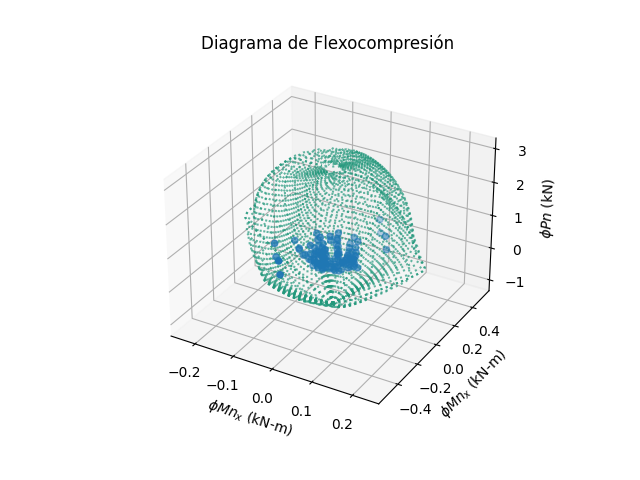

In [9]:
#Diagrama a flexocompresión
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i,theta_ in enumerate(theta):
    col.plot_flex_comp(phi_Pn[i],phi_Mn_x[i],phi_Mn_y[i],ax)
    
ax.scatter(cargas['M2']/10**6,cargas['M3']/10**6,cargas['P']*-1/10**6)
plt.title('Diagrama de Flexocompresión')
ax.set_xlabel("$\phi Mn_x$ (kN-m)")
ax.set_ylabel("$\phi Mn_x$ (kN-m)")
ax.set_zlabel("$\phi Pn$ (kN)")
plt.show()

<IPython.core.display.Javascript object>


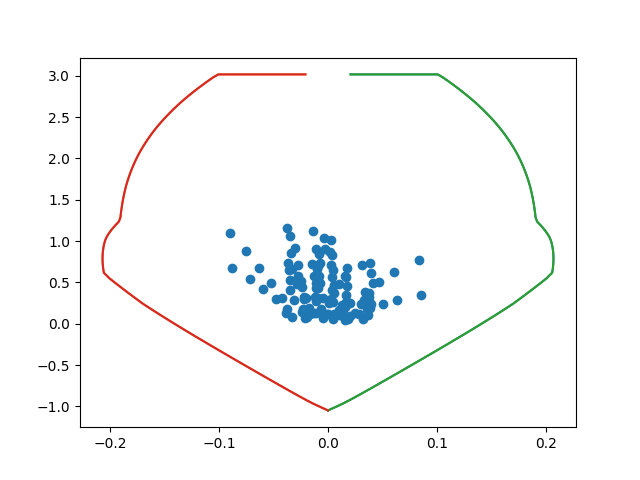

In [10]:
fig, ax = plt.subplots()
ax.plot(phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.plot(-phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.plot(phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.plot(-phi_Mn_x[1]/10**6, phi_Pn[1]/10**6)
ax.scatter(cargas['M2']/10**6,cargas['P']*-1/10**6)
plt.show()

<IPython.core.display.Javascript object>


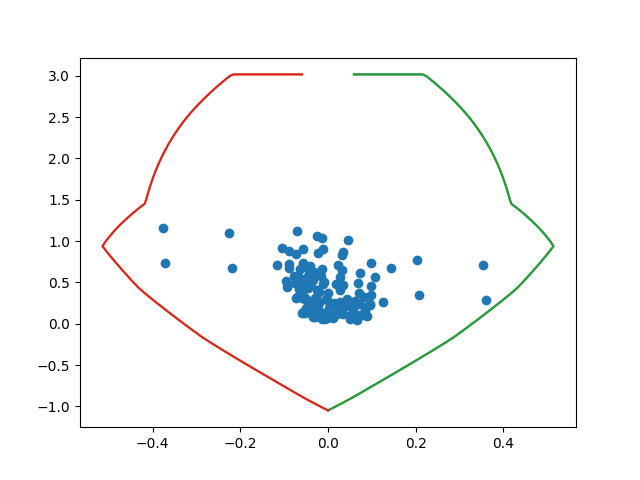

In [11]:
fig, ax = plt.subplots()
ax.plot(phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.plot(-phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.plot(phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.plot(-phi_Mn_y[-1]/10**6, phi_Pn[-1]/10**6)
ax.scatter(cargas['M3']/10**6,cargas['P']*-1/10**6)
plt.show()

## Comprobación Viga débil Columna Fuerte

La resistencia a la flexión de las columnas debe ser por lo menos 6/5 de la resistencia a la flexion de la viga que se apoya en ella:

$ \hspace{5.5cm} \Sigma M_{nc} \geq (6/5) \Sigma M_{nb} $

In [17]:
#Datos de la viga
bv = 25*cm
hv = 40*cm
dv = hv-9*cm #peralte efectivo
As = 4*A_5 #4 aceros #5

#Momento Resistente máximo con acero en tracción solamente
phi_f = 0.9
av = As*fy/(0.5*fc*bv) #Altura del bloque en compresión
Mnv = As*fy*(dv-av/2)
phi_Mnv = phi_f*Mnv

In [18]:
#Elegimos la menor carga que no se encuetra en el último nivel
P_min = cargas[cargas.Piso!=6]['P'].max()

#Valor de a en el que se encuentra la carga mínima
b = geom['b']
a_des,i = col.find_a(b,Pn[0],P_min)

#Momento de diseño
Mnx_des = Mn_x[0][i]

#Verificación:
if 2*Mnx_des > 1.2*(2*Mnv):
    print('OK')
else:
    print('Viga más fuerte que la columna')

OK


## Desarrollo del acero en la columna
A lo largo de la altura libre de la columna, el refuerzo longitudinal debe seleccionarse de manera que:

$\hspace{5cm} 1.25\cdot l_d = l_u/2 $
- $l_u$ luz libre de la columna
- $l_d $ longitud de desarrollo del acero

In [22]:
#Cálculo de la longitud de desarrollo sin considerar confinamiento de estribos
lu = 1.95*m
lamb = 1
psi_g = 1
psi_e = 1
psi_s1 = 1
psi_s2 = 0.8
psi_ts = 1.3
psi_ti = 1
db = 0.75 * pulg

psi_ts_e = psi_ts*psi_e 
if psi_ts_e > 1.7:
    psi_ts_e = 1.7
    
sqrt_fc = (fc/10**6)**0.5*MPa
if sqrt_fc > 8.3*MPa:
   sqrt_fc = 8.3*MPa

ld3 = fy/(1.1*lamb*sqrt_fc)*psi_g*psi_e*psi_s2*psi_g*db
ld3

1.269790065293218

In [23]:
#Considerando el efecto de los estribos:
r = geom['r']
d_st = steel['d_st']
nb = steel['n_c']

cb1 = r+d_st+db*0.5
cb2 = (b-2*r-2*d_st-db)/(nb-1)/2
cb = min(cb1,cb2)

k_tr = 0

#restricciones de la norma
alpha = (cb+k_tr)/db
if alpha > 2.5:
    alpha = 2.5

#Por tanto:
ld3 = ld3/alpha 
ld3

0.5079160261172871

In [24]:
#Verificación
if 1.25*ld3 <= lu/2:
    print('Ok')
else:
    print('El acero no puede desarrolarse en la columna')

Ok


## Diseño de estribos

### Longitud de confinamiento:
Es la longitud $l_o$ medida desde cada cara del nudo a ambos lados de cualquier sección donde pueda ocurrir fluencia por flexión como resultado de desplazamientos laterales que exceden el rango elástico de comportamiento.

In [26]:
hm= 2.1*m
h = geom['h']
Lo = max(b,h,hm/6,45*cm)
Lo

0.75

### Distribución de los estribos en la sección
La cantidad de refuerzo transversal debe cumplir con le exigido en la tabla 18.7.5.4:
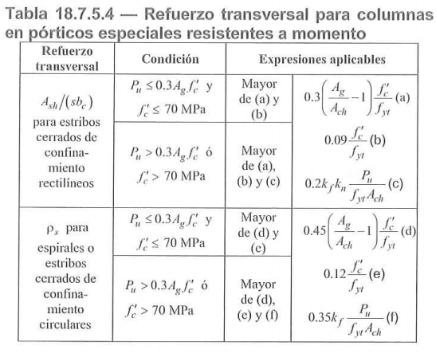

- $k_f$: factor de resistencia del concreto $k_f=\frac{f'_c}{175}+0.6 \geq 1.0$
- $k_n$: factor de efectividad del confinamiento $k_n=\frac{n_l}{nl-2}$
- $n_l$: número de barras longitudinales alrededor del perímetro del núcleo de una columna con estribos cerrados de confinamiento que están soportados lateralmente por una esquina del estribo cerrado de confinamiento con ganchos sísmicos

In [30]:
s = 10*cm #Separación inicial de estribos
bc = b-2*r
hc = h-2*r
Ach = bc*hc
P_max = cargas.P.min()

#Dirección X:
Ash1 = 0.09*s*bc*fc/fy
Ash2 = 0.3*s*bc*(Ag/Ach-1)*fc/fy
Ash3 = 0
nl = 10
if 0.3*fc*Ag < P_max:
    kf = fc/175+0.6
    if kf < 1.0:
        kf = 1.0 
    kn = nl/(nl-2)
    Ash3 = 0.2*kf*kn*P_max/(fy*Ach)
Ashx = max(Ash1,Ash2,Ash3)
Ashx*10**4

1.8268656716417901

In [31]:
#Revisión Y
Ash1 = 0.09*s*hc*fc/fy
Ash2 = 0.3*s*hc*(Ag/Ach-1)*fc/fy
Ash3 = 0
nl = 10
if 0.3*fc*Ag < P_max:
    kf = fc/175+0.6
    if kf < 1.0:
        kf = 1.0 
    kn = nl/(nl-2)
    Ash3 = 0.2*kf*kn*P_max/(fy*Ach)
Ashy = max(Ash1,Ash2,Ash3)
Ashy*10**4

4.53333333333333

In [42]:
#Comprobracion:
Ashpx = 2*A_4 #dos ramas de acero #4
Ashpy = 4*A_3+2*A_4 #dos ramas de acero #4 y cuatro ramas de #3

if Ashpx < Ashx:
    print('Acero insuficiente en X')
else:
    print('Acero colocado en el sentido X: {:.2f} cm^2'.format(Ashpx*10**4))
if Ashpy < Ashy:
    print('Acero insuficiente en Y')
else:
    print('Acero colocado en el sentido Y: {:.2f} cm^2'.format(Ashpy*10**4))

Acero colocado en el sentido X: 2.53 cm^2
Acero colocado en el sentido Y: 5.38 cm^2


### Cortante que toma el acero considerando rótula en la columna

In [44]:
#Diagramas a flexocompresión mayorados
d_steel_may = {'fy' : 1.25*420*MPa, #Esfuerzo a la fluencia del acero
               'Es' : 200000*MPa, #Módulo de elasticidad del acero
               'eps_y' : 1.25*420*MPa/(200000*MPa)} #Deformación de fluencia del acero
#Momentos en X
theta = 0
flex_comp_data = col.flex_comp_data(d_conc, d_steel_may, 
                                    geom, steel, phi, theta)
Pn_x_may = flex_comp_data[0]
Mn_x_may = flex_comp_data[2]

#Momentos en Y
theta = 90
flex_comp_data = col.flex_comp_data(d_conc, d_steel_may, 
                                    geom, steel, phi, theta)
Pn_y_may = flex_comp_data[0]
Mn_y_may = flex_comp_data[3]

<IPython.core.display.Javascript object>


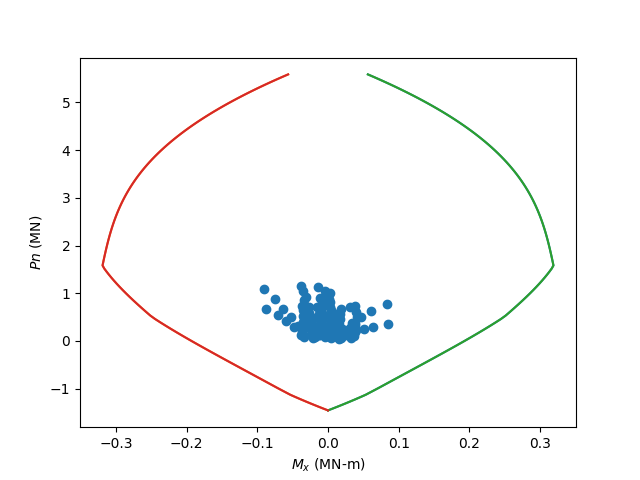

In [45]:
#Diagrama en el eje x    
fig, ax = plt.subplots()
ax.plot(Mn_x_may/10**6, Pn_x_may/10**6)
ax.plot(-Mn_x_may/10**6, Pn_x_may/10**6)
ax.plot(Mn_x_may/10**6, Pn_x_may/10**6)
ax.plot(-Mn_x_may/10**6, Pn_x_may/10**6)
ax.scatter(cargas['M2']/10**6,cargas['P']*-1/10**6)
ax.set_xlabel("$M_x$ (MN-m)")
ax.set_ylabel("$Pn$ (MN)")
plt.show()

<IPython.core.display.Javascript object>


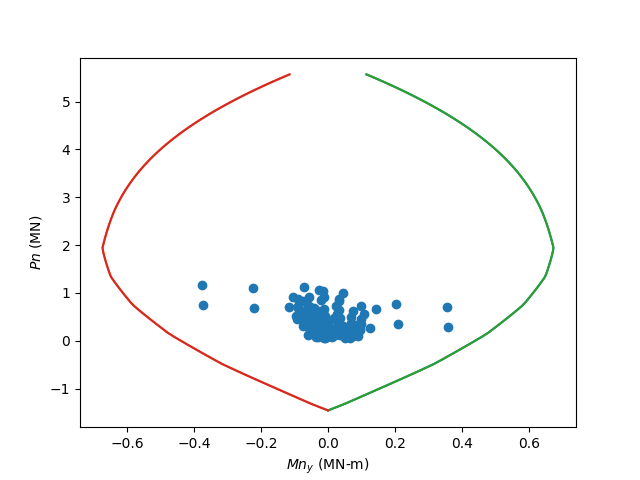

In [46]:
#Diagrama en el eje y  
fig, ax = plt.subplots()
ax.plot(Mn_y_may/10**6, Pn_y_may/10**6)
ax.plot(-Mn_y_may/10**6, Pn_y_may/10**6)
ax.plot(Mn_y_may/10**6, Pn_y_may/10**6)
ax.plot(-Mn_y_may/10**6, Pn_y_may/10**6)
ax.scatter(cargas['M3']/10**6,cargas['P']*-1/10**6)
ax.set_xlabel("$Mn_y$ (MN-m)")
ax.set_ylabel("$Pn$ (MN)")
plt.show()

In [47]:
#Momentos Probables
P_max = cargas['P'].min()
a1,i = col.find_a(b,Pn_x_may,P_max)
Mnx_des = Mn_x_may[i]
Pnx_des = Pn_x_may[i]

a2,i = col.find_a(h,Pn_y_may,P_max)
Mny_des = Mn_y_may[i]
Pny_des = Pn_y_may[i]

In [48]:
#Cortantes ultimas por capacidad
hn1 = 1.95*m
hn2 = 2.1*m
Vux = 2*Mnx_des/hn2
Vuy = 2*Mny_des/hn1

In [49]:
#Cortante que toma el concreto:
phi_c =0.75 #factor de reduccion
#Direccion X
Y = abs(P_max)/(6*Ag)
Y = min(Y,0.05*fc)
Vcx1 = (0.17*lamb*(fc/MPa)**0.5*MPa+Y)*h*(b-r-d_st)
Vcx2 = (0.42*lamb*(fc/MPa)**0.5*MPa)*h*(b-r-d_st)
Vcx = min(Vcx1,Vcx2)
Vsx = (Vux-phi_c*Vcx)/phi_c
#Direccion Y
Vcy1 = (0.17*lamb*(fc/MPa)**0.5*MPa+Y)*b*(h-r-d_st)
Vcy2 = (0.42*lamb*(fc/MPa)**0.5*MPa)*b*(h-r-d_st)
Vcy = min(Vcy1,Vcy2)
Vsy = (Vuy-phi_c*Vcy)/phi_c

In [50]:
#Comprobacion de la sección transversal por cortante
Vumx = phi_c*(Vcx+0.66*(fc/MPa)**0.5*MPa*h*(b-r-d_st))
Vumy = phi_c*(Vcy+0.66*(fc/MPa)**0.5*MPa*b*(h-r-d_st))

if Vumx < Vux:
    print('Aumentar seccion')
else:
    print('OK')
    
if Vumy < Vuy:
    print('Aumentar seccion')
else:
    print('OK')

OK
OK


In [53]:
#Separación de estribos:
#Direccion X
n = 2
n2 = 0
theta = math.radians(45)
Ast = A_4*n+A_3*n2*math.cos(theta)
sx = Ast*fy*(h-r-d_st)/Vsy
sx*100

15.051571945366929

In [54]:
#Direccion Y
n1 = 2
n2 = 4
n3 = 0
theta = math.radians(45)
Ast = A_4*n1+A_3*n2+A_3*n3*math.cos(theta)
sy = Ast*fy*(b-r-d_st)/Vsx
sy*100

205.20265008327993

In [55]:
#Separacion minima
d_p = steel['d_p']
s = min(sx,sy,6*d_p,15*cm)
s

0.09525

### Cortante que toma el acero considerando rótula en las vigas

In [62]:
#Viga en el sentido Y:
bv1 = 25*cm
hv1 = 40*cm
dv1 = hv1 - 9*cm
As1 = 4*A_5
ln1 = 5.65*m-0.2*m
#Vigas en el sentido X
bv2 = 35*cm
hv2 = 55*cm
dv2 = hv2 - 6*cm
As2 = 2*A_6+2*A_5
As3 = 3*A_5
ln2 = 4.56*m-0.35*m
ln3 = 4*m-0.35*m

In [57]:
#Momentos Probables en las vigas
#Sentido X
a1 = As1*1.25*fy/(0.85*fc*bv1)
Mpx = As1*1.25*fy*(dv1-a1/2)
Vux = 4*Mpx/(2*hn2)
#Sentido Y
a2 = As2*1.25*fy/(0.85*fc*bv2)
Mpy1 = As2*1.25*fy*(dv2-a2/2)
a3 = As3*1.25*fy/(0.85*fc*bv2)
Mpy2 = As3*1.25*fy*(dv2-a3/2)
Mpy = max(Mpy1,Mpy2)
Vuy = 2*Mpy/(2*hn2)

In [61]:
#Cortantes producidos por las vigas en X
V2 = 2*Mpx/ln2
V1 = 2*Mpx/ln3
#Longitud de diseño de la columna en X
lc1 = 0.5*hn2+hv
#Cortante de la columna en el sentido X
Vcolx = 2*Mpx/lc1 + (V1+V2)*b/2/lc1
Vcolx

164547.8928522976

In [66]:
#Cortantes producidos por la viga en Y
V3 = (Mpy1+Mpy2)/ln1
#Longitud de diseño de la columna en Y
lc2 = 0.5*hn1+hv2
#Cortante de la columna en el sentido Y
Vcoly = Mpy/lc2+V3*h/2/lc2
Vcoly

166266.7272259201

## Fuerza cortante en el Nudo:

In [69]:
#Sentido X (dos vigas llegando al nudo)
T1 = As1*fy
T2 = T1
Vux = T1+T2-Vcolx
Vux

500505.6734631682

In [70]:
#Sentido Y (una viga en el nudo)
T3 = As2*fy
Vuy = T3-Vcoly
Vuy

239415.948226514

In [71]:
#En nudos viga columna de porticos a momento especiales usamos un factor de:
phi_c = 0.85
fact = {'IA':1.7,
       'IB':1.3,
       'IC':1.3,
       'ID':1.0,
       'IIA':1.3,
       'IIB':1.0,
       'IIC':1.0,
       'IID':0.7}

#Análisis en X:
tipox = 'I' #columna continua
v_c = 'y' #continuidad de la viga después del nudo
if v_c == 'y':
    if bv2 >= 0.75*h:
        tipox += 'A'
    else:
        tipox += 'B'
else:
    if bv2 >= 0.75*h:
        tipox += 'C'
    else:
        tipox += 'D'
tipox

'IB'

In [72]:
#Análisis en Y:
tipoy = 'I' #columna continua
v_c = 'n' #continuidad de la viga después del nudo
if v_c == 'y':
    if bv2 >= 0.75*h:
        tipoy += 'A'
    else:
        tipoy += 'B'
else:
    if bv2 >= 0.75*h:
        tipoy += 'C'
    else:
        tipoy += 'D'
tipoy

'ID'

In [75]:
#Cortante que resiste el nudo direccion X
befx = min(bv1+b,bv1) #Ancho efectivo del nudo en X
Ajx = befx*b
phiVnx = phi_c*fact[tipox]*(fc/MPa)**0.5*MPa*Ajx
phiVnx

443077.78750604275

In [77]:
#Cortante que resiste el nudo direccion X
befy = min(bv2+h,bv2) #Ancho efectivo del nudo en X
Ajy = befy*h
phiVny = phi_c*fact[tipoy]*(fc/MPa)**0.5*MPa*Ajy
phiVny

1022487.2019370218

In [82]:
#Propuesta al nudo en X
b = 40*cm
bv1 = 35*cm
fc = 28*MPa
befx = min(bv1+b,bv1)
Ajx = b*befx
phiVnx = phi_c*fact[tipox]*(fc/MPa)**0.5*MPa*Ajx
phiVnx

818595.4556433845